In [2]:
!pip install -q xlrd
!git clone https://github.com/Lossophy/BINA-Projekt.git

fatal: destination path 'BINA-Projekt' already exists and is not an empty directory.


Vorbereitung der benötigten Bibliotheken

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

Import & Überprüfung der der Daten

In [13]:
# Datei einlesen
df = pd.read_csv('/content/BINA-Projekt/Data/ogd115_gest_bilanz.csv')

# Daten überprüfen
print(df.head())


   Jahr           Rubrik Energietraeger        TJ
0  1980  Bruttoverbrauch   Elektrizität  -29450.0
1  1980  Bruttoverbrauch  Erdölprodukte  321250.0
2  1980  Bruttoverbrauch      Fernwärme       0.0
3  1980  Bruttoverbrauch            Gas   36280.0
4  1980  Bruttoverbrauch    Holzenergie   26280.0


**Beschreibung der Daten:**
Die Daten wurden von der  SFOE (Swiss Federal Office of Energy) heruntergeladen. Unter folgendem Link https://opendata.swiss/en/dataset/energiebilanz-der-schweiz/resource/1957ce24-bc06-40f8-a630-6db5bee3c419.


---
Der Datensatz hat die Spalten "Jahr", "Rubrik", "Energieträger" und "TJ".

Die Daten sind vom Jahr 1980 bis und mit 2023.

Es werden die folgenden Rubriken unterschieden:


*   Bruttoverbrauch =
*   Eigenverbrauch des Energiesektors, Netzverluste, Verbrauch der Speicherungen =
*   Endverbrauch - Dienstleistungen =
*   Endverbrauch - Haushalte =
*   Endverbrauch - Industrie =
*   Endverbrauch - Statistische Differenz inkl. Landwirtschaft =
*   Endverbrauch - Total =
*   Endverbrauch - Verkehr =
*   Energieumwandlung - Diverse Erneuerbare =
*   Energieumwandlung - Gaswerke =
*   Energieumwandlung - Kernkraftwerke =
*   Energieumwandlung - Raffinerien =
*   Energieumwandlung - Wasserkraftwerke
*   Energieumwandlung - konventionell-thermische Kraft-, Fernheiz- und Fernheizkraftwerke =
*   Export =
*   Import =
*   Inlandproduktion =
*   Lagerveränderung =
*   Nichtenergetischer Verbrauch =




1 Terajoule entspricht dabei 277'777,777 KWh. Zur besseren Einordnung kann die grösse der Energieeinheit mit folgendem Durchschnittswert dargestellt werden. Ein durchschnitts Haushalt mit 4 Personen in der Schweiz braucht ca. 4'500 KWh pro Jahr (https://www.energieheld.ch/renovation/nachhaltig-leben/energieverbrauch).

Als erstes möchten wir sehen, wie sich der allgemeine Verbrauch je Energieträger verändert hat.

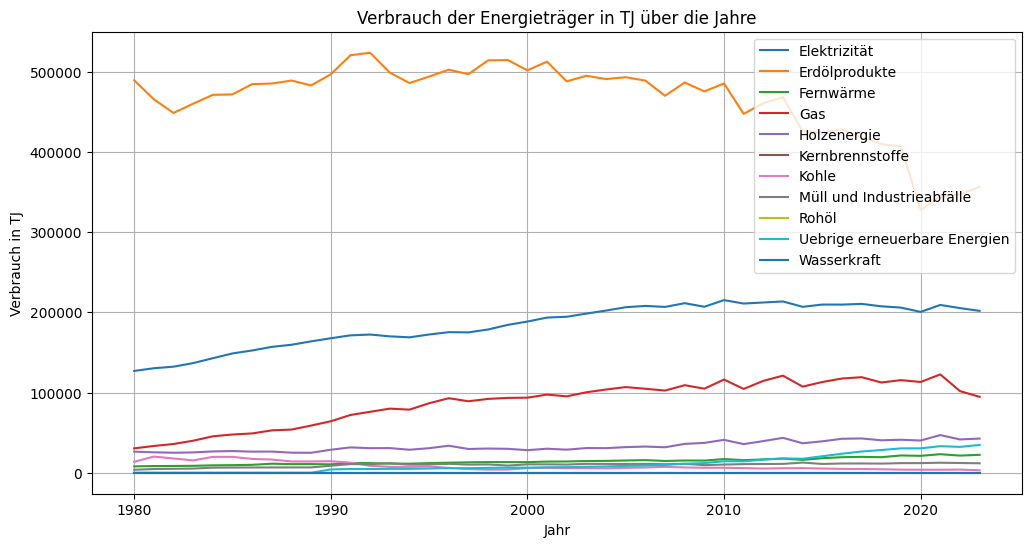

In [14]:
# Daten filtern und vorbereiten
df_filtered = df[df['Energietraeger'].isin(['Elektrizität','Erdölprodukte','Fernwärme','Gas','Holzenergie','Kernbrennstoffe','Kohle','Müll und Industrieabfälle','Rohöl','Uebrige erneuerbare Energien','Wasserkraft'])]
df_filtered = df[df['Rubrik'].isin(['Endverbrauch - Total'])]
df_filtered = df_filtered.groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_pivot = df_filtered.pivot(index='Jahr', columns='Energietraeger', values='TJ')

# Plot erstellen
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], label=column)

plt.xlabel('Jahr')
plt.ylabel('Verbrauch in TJ')
plt.title('Verbrauch der Energieträger in TJ über die Jahre')
plt.legend()
plt.grid()
plt.show()


Um einen besseren Überblick über die genauere Verteilung der Energieträger zu erhalten, wollen wir nun Pie-Charts pro Jahr anschauen.

Output()

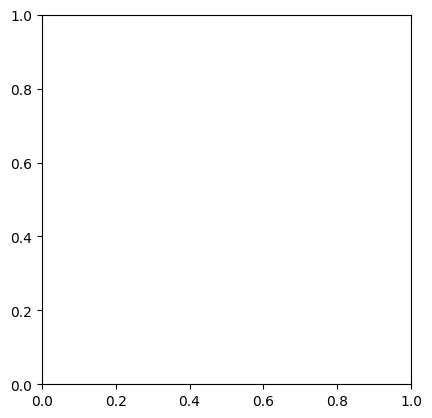

In [32]:
# Interaktive Funktion definieren
def plot_daten(jahr):
    gefiltert = df[(df['Jahr'] == jahr) & (df['Rubrik'] == 'Endverbrauch - Total')]

    if gefiltert.empty:
        print("Keine Daten für diese Kombination.")
        return

    # Gruppieren nach Energieträger und Summe von TJ berechnen
    energie_verbrauch = gefiltert.groupby('Energietraeger')['TJ'].sum()

    # Pie-Chart erstellen
    plt.figure(figsize=(8, 8))  # Größe des Diagramms anpassen
    plt.pie(energie_verbrauch, labels=energie_verbrauch.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Verbrauch der Energieträger im Jahr {jahr}")
    plt.axis('equal')  # Gleichmäßiger Kreis
    plt.show()

  #Interaktive Ansicht verbinden
ui = widgets.VBox([jahr_widget])
out = widgets.interactive_output(plot_daten, {'jahr': jahr_widget,})

display(ui, out)